In [3]:
import numpy as np
from astropy.constants import c, G, M_sun
from astropy.cosmology import Planck15
from scipy.constants import pi
import astropy.units as u
from scipy.integrate import quad
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# constants
pixels = 256
src_length = 3.0
kappa_length = 8
sigma_v = 75 * u.km / u.s # Milky way velocity dispersion
x_c = 0.1
cosmo = Planck15
z_lens = 0.5 
z_src = 1
DL = cosmo.angular_diameter_distance(z_lens)
DLS = cosmo.angular_diameter_distance_z1z2(z_lens, z_src)
DS = cosmo.angular_diameter_distance(z_src)
xi_0 = (4 * pi * (sigma_v / c)**2 * DL * DLS / DS).to(u.pc)
Sigma_cr = (c**2 / 4 / pi / G * DS / DL / DLS).to(u.kg / u.pc**2)
Sigma_cr / M_sun


<Quantity 3001.93535935 1 / pc2>

# Sopthened Singular Isothermal Sphere profile

$$
    \rho(r) = \frac{\sigma_V^2}{2 \pi G r^2}
$$
So the surface density profile is (by the Born approximation)
$$
\begin{align}
    \Sigma(\xi) &= \frac{\sigma_v^2}{2 \pi G} \int_{-\infty}^\infty \frac{dz}{\xi^2 + dz^2} \\
            &= \frac{\sigma_v^2}{\pi G} \frac{1}{\xi} \left(\arctan \frac{z}{\xi} \right)_{0}^\infty \\
            &= \frac{\sigma_v^2}{2G \xi}
\end{align}
$$

A typical scale for this problem is
$$
    \xi_0 = 4 \pi \left( \frac{\sigma_v}{c} \right)^2 \frac{D_L D_{LS}}{D_S}
$$
where $D_i$ are angular diameter distances. A more natural scale for the problem is the Einstein radius (defined here in term of the enclosed mass)
$$
    \theta_E = \sqrt{\frac{4 G M(\xi < \theta_E)}{c^2} \frac{D_{LS}}{D_L D_S}}
$$

We make the problem adimensional by using $x = \xi / \xi_0$, with 
$$\Sigma_{cr} = \frac{c^2}{4 \pi G} \frac{D_S}{D_L D_{LS}}$$

We introduce a core radius to avoid the singularity

In [5]:
# x should be a position tensor for an image: shape = [pixels, pixels, 2]

def kappa(x, e, x_c=x_c):
    r = elliptical_r(x[..., 0], x[..., 1], e)
    return (r**2 + 2 * x_c**2) / 2 / (r**2 + x_c**2)**(3/2)

def alpha(x, e, x_c):
    r = elliptical_r(x[..., 0], x[..., 1], e)
    # pseudo elliptical deviation angles
    alpha_hat = x / np.sqrt(r**2 + x_c**2)[..., np.newaxis]
    alpha_hat = np.sqrt(alpha_hat[..., 0]**2 + alpha_hat[..., 1]**2)
    alpha_1 = x[..., 0] / (1 - e) / r * alpha_hat
    alpha_2 = x[..., 1] * (1 - e) / r * alpha_hat
    out = np.stack([alpha_1, alpha_2], -1)
    return out

def shear_pseudovector(x, e, x_c=x_c):
    r = elliptical_r(x[..., 0], x[..., 1], e)
    phi = np.arctan2(x[..., 1], x[..., 0])
    amp = -0.5 * (r**2 + 2 * x_c**2) / (r**2 + x_c**2)**(3/2)
    gamma_1 = - 0.5 * amp *  np.cos(2 * phi)
    gamma_2 = - 0.5 * amp * np.sin(2 * phi)
    return gamma_1, gamma_2

def lens_equation(x, e, x_c=x_c):
    y = x - alpha(x, e, x_c)
    return y
    
def rotate(x, y, phi):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x) - phi
    x1 = r * np.cos(theta)
    x2 = r * np.sin(theta)
    return x1, x2

def elliptical_r(x, y, e):
    return np.sqrt(x**2 / (1 - e) + y**2 * (1 - e))

def source_image(x0, y0, e, phi, sigma):
    x = np.linspace(-1, 1, pixels) * src_length
    xx, yy = np.meshgrid(x, x)
    xx, yy = rotate(xx, yy, phi)
    r = elliptical_r(xx - x0, yy - y0, e)
    image = np.exp(-0.5 * r**2 / sigma**2)
    image /= image.sum()
    return image, xx, yy, x
    

Text(0.5, 1.0, 'Lensed image')

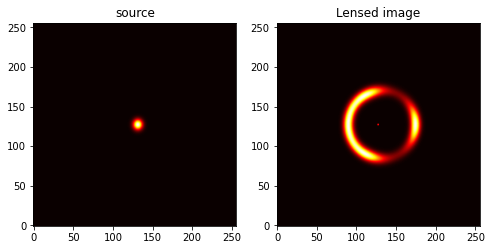

In [10]:
x0 = 0.1
y0 = 0
e = 0.1
phi = 0
sigma = 0.1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
image, x, y, _x = source_image(x0, y0, e, phi, sigma)

positions = np.column_stack([x.ravel(), y.ravel()])

out = lens_equation(np.stack([x, y], -1), e)
x_l, y_l = [out[..., i] for i in range(2)]
lensed_image = griddata(positions, image.ravel(), (x_l.ravel(), y_l.ravel())).reshape([pixels, pixels])

ax1.imshow(image, origin="lower", cmap="hot")
ax2.imshow(lensed_image, cmap="hot", origin="lower")
ax1.set_title("source")
ax2.set_title("Lensed image")

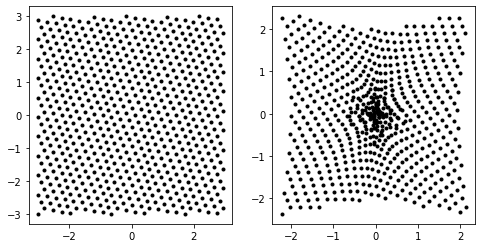

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.plot(x.ravel()[::100], y.ravel()[::100], "k.")
ax2.plot(x_l.ravel()[::100], y_l.ravel()[::100], "k.")

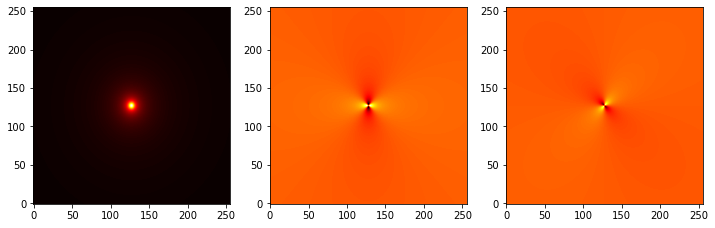

In [12]:
k = kappa(positions, e).reshape([pixels, pixels])
g1, g2 = shear_pseudovector(positions, e)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.imshow(k, cmap="hot", origin="lower")
ax2.imshow(g1.reshape([pixels, pixels]), cmap="hot", origin="lower")
ax3.imshow(g2.reshape([pixels, pixels]), cmap="hot", origin="lower")

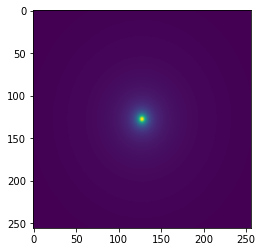

In [13]:
plt.imshow(np.sqrt(g1**2 + g2**2).reshape([pixels, pixels]))